Use the final csv files for train and test and use various models to train and score them

# 1. Import and Load

In [9]:
import pandas as pd
import numpy as np

# models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm

# processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# parameters search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# scoring
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

# explain
import shap
import datetime

# save model
import pickle
import os
import joblib



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [1]:
import sys
print(sys.executable)  # Check Python executable path
print(sys.path)        # Check library paths

/Users/sherlyhartono/anaconda3/envs/myenv/bin/python
['/Users/sherlyhartono/Desktop/code2/DS/Energy/microclimate_model', '/Users/sherlyhartono/anaconda3/envs/myenv/lib/python310.zip', '/Users/sherlyhartono/anaconda3/envs/myenv/lib/python3.10', '/Users/sherlyhartono/anaconda3/envs/myenv/lib/python3.10/lib-dynload', '', '/Users/sherlyhartono/anaconda3/envs/myenv/lib/python3.10/site-packages']


# 2. Data Class

In [2]:
TRAIN_PATH = "../data/microclimate_model/combined/three_bldgs_dropped.csv"
TEST_PATH = "../data/microclimate_model/combined/three_bldgs_J9_dropped.csv"
OUTPUT_PATH = "./output/"

In [3]:
"""
This class encapsulates the datas that we will need for training, testing, and scoring
It contains getters for the train and test data.
It also contains a method that creates a df with bldgname column (undummified df) and prediction, actual columns
"""
class Data(object):
    def __init__(self, train_path, test_path, isDropISTB = True):
        """
        Parameters:
            train_path (str) : The file path for the trainning csv file. 
            test_path (str) : The path for the test csv file. 
        
        Both train and test datas have 16 columns with buildings already encoded
        """
        dropped_cols = ['CHWTON/SQM']
        self.train_val_df = pd.read_csv(train_path, index_col=0)
        
        # 1. Undummify data
        # df that only has "index" and "bldgname" 
        # we will use this df for plotting
            
        # A. undfummify for Validation
        self.X_train_val = self.train_val_df.drop(columns=dropped_cols)
        self.y_train_val = self.train_val_df['CHWTON/SQM']  
        X_train, X_val, y_train, y_val = train_test_split(self.X_train_val, 
                                                      self.y_train_val, 
                                                      test_size=0.3, 
                                                      random_state=20)
        
        self.df_undum_val = self.undummify(X_val)
        # - drop all the columns apart from bldgname with date_time as index
        cols_to_keep = ["bldgname"]
        # self.df_undum_val = self.df_undum_val.drop(self.df_undum_val.columns.difference(cols_to_keep), 1)
        self.df_undum_val = self.df_undum_val.drop(columns=self.df_undum_val.columns.difference(cols_to_keep))

        
        
        # B. Undummify for Test
        self.test_df = pd.read_csv(test_path, index_col=0)
        self.X_test = self.test_df.drop(columns=dropped_cols)
        self.y_test = self.test_df['CHWTON/SQM'] 
        
        self.df_undum_test = self.undummify(self.X_test)
        # self.df_undum_test = self.df_undum_test.drop(self.df_undum_test.columns.difference(cols_to_keep), 1)
        self.df_undum_test = self.df_undum_test.drop(columns=self.df_undum_val.columns.difference(cols_to_keep))

        
        # 2. Finalise X train and X test data
        if isDropISTB:
            dropped_cols = ['CHWTON/SQM', "bldgname_ISTB 4"]
        self.X_train_val = self.train_val_df.drop(columns=dropped_cols)
        self.X_test = self.test_df.drop(columns=dropped_cols)
        

        
    def undummify(self, df, prefix_sep="_"):
            """
            Inner function to undummify pandas df
            
            Return:
                undummified_df: the undummied df containing only date_time as index and bldgname column
            """
            cols2collapse = {
                item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
            }
            series_list = []
            for col, needs_to_collapse in cols2collapse.items():
                if needs_to_collapse:
                    undummified = (
                        df.filter(like=col)
                        .idxmax(axis=1)
                        .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                        .rename(col)
                    )
                    series_list.append(undummified)
                else:
                    series_list.append(df[col])
            undummified_df = pd.concat(series_list, axis=1)
            return undummified_df
        
    def get_xy_trainval(self):
        """
        Return the X and y for training data which we can split to train and validation data later.
        """
        return self.X_train_val, self.y_train_val
    
    def get_xy_test(self):
        """
        Return the X and y for June 9th test data
        """
        return self.X_test, self.y_test
    
    def create_df_bldgs(self, y_pred, y_actual_or_scen, is_val=False, is_scenario=False):
        """
        Create 4 dataframes that consist of "bldgname, predicted, actual" value. 
        it will be returned in the following format:
        [df_combined, [df_bldg1, df_bldg2, df_bldg3]]
        """
        df_bldgs = []
        
        # 1. create a copy
        if is_val:
            df_undum = self.df_undum_val.copy()
        else:
            df_undum = self.df_undum_test.copy()
        
        # 2. set the first column
        first_plot_name = "Predicted"
        df_undum[first_plot_name] = y_pred
        
        # 3. set the second column
        if is_scenario :
            second_plot_name = "Scenario Prediction"
        else:
            second_plot_name = "Actual"

        df_undum[second_plot_name] = y_actual_or_scen
        
        # 4. split df by bldgname
        for bldgname in df_undum['bldgname'].unique():
            # - get the df by name
            df_bldg = df_undum[df_undum['bldgname'] == bldgname]
            
            # - save this df in list
            df_bldgs.append(df_bldg)

                
        return [df_undum, df_bldgs]

# 3. Train Test Class

In [4]:
"""
This class encapsulates the the training, testing, and plotting process.
It stores the train and test datas that's already split to X and y
"""
class TrainTest(object):
    def __init__(self, X_train_val, y_train_val, X_test, y_test):
        
        # - scores_df to display the scores for all our models
        self.columns=['model','r2_val', 'r2_test', 'rmse_test','mbe_test']
        self.scores_df= pd.DataFrame(columns=self.columns)
        
        # - train and test data
        self.X_train_val = X_train_val
        self.y_train_val = y_train_val
        self.X_test = X_test
        self.y_test = y_test
        self.tuned_model_list = []
            
    def get_scores_df(self):
        return self.scores_df
    
    
    def train_and_store_score(self, model, model_name):
        """
        This function will train the model given as parameter using the training data. It will compute the r2 validation score
        and append this as a new row to scores_df.
        
        Parameters:
            model (regressor model) : The model object that will be trained and used in validation.
                It can be RF, XGB, LGBM, or catboost regressor
                
            model_name (str) : the name of the model displayed in scores_df
            
        Return:
            model : this is relevant if we are doing randomized search. it will return the best model
        """
        print("\nmodel_name>>>", model_name)
        # 1. Train-Val Split
        X_train, X_val, y_train, y_val = train_test_split(self.X_train_val, 
                                                          self.y_train_val, 
                                                          test_size=0.3, 
                                                          random_state=20)

        # 2. fit model and time it
        start_time = datetime.datetime.now()
        print("start time>>>", start_time)
        model.fit(X_train, y_train)
        end_time = datetime.datetime.now()
        print("end time>>>>", end_time)
        dur_s = (end_time - start_time).total_seconds()
        print("dur", dur_s)
        
        
        # - Get best params if it's a random or grid search
        if(("random" in model_name)) or ("grid" in model_name):
            model = model.best_estimator_
            # print("params", model.get_params())
            
        # 3. get validation R2 score
        val_r2 = model.score(X_val, y_val)
        
        # 4. store score
        new_row_data = {'model':model_name, 
                        "r2_val":val_r2, 
                        "r2_test":0, 
                        'rmse_test':0, 
                        'mbe_test':0, 
                        'train_time_s': dur_s}
        new_row = pd.DataFrame.from_records([new_row_data])
        self.scores_df = pd.concat([self.scores_df, new_row])
        
        return model
    
    def get_MBE(self, y_true, y_pred):
        '''
        Parameters:
            y_true (array): Array of observed values
            y_pred (array): Array of prediction values

        Returns:
            mbe (float): Bias score
        '''
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_true = y_true.reshape(len(y_true),1)
        y_pred = y_pred.reshape(len(y_pred),1)   
        diff = (y_pred-y_true)
        mbe = diff.mean()
        return mbe

        
    def test_and_store_score(self, model, model_name):
        """
        This function will use the given trained model to compute the y_pred using the X_test data.
        It will then compute the mbe, r2, and rmse result and insert it to scores_df. 
        
        Parameters:
            model (regressor model): The model that has been trained and will be used to predict y using the test data
                It can be RF, XGB, LGBM, or catboost regressor
            model_name (string): the name of the model displayed in scores_df
        """
        print("\ntest and store scores..", model_name)
        # print(model.get_params())
        # 1. Get prediction for the test data
        y_pred = model.predict(self.X_test)
        
        # 2. get the three scores
        r2 = r2_score(self.y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(self.y_test, y_pred))
        mbe = self.get_MBE(self.y_test, y_pred)
        
        # 3. update scores_df with the 3 scores above
        row_to_update = self.scores_df["model"] == model_name
        
        
        if row_to_update.empty:
            # append just the test score
            new_row_data = {'model':model_name, 
                        "r2_val":0, 
                        "r2_test":r2, 
                        'rmse_test':rmse, 
                        'mbe_test':mbe, 
                        'train_time_s': 0}
            new_row = pd.DataFrame.from_records([new_row_data])
            self.scores_df = pd.concat([self.scores_df, new_row])
            
        else:
            col_to_update = ['r2_test','rmse_test', 'mbe_test']
            self.scores_df.loc[row_to_update, col_to_update] = [r2, rmse, mbe]
        
        
    def train_test_models(self, model_list):
        """
        This function will take a list of models and train them. if the model is from randomized search, it will
        return the model with best params. This best model will be used to test and store score.
        Using the same model, it will plot the SHAP values.
        
        Parameters:
            model_list (regressor models): list of all models that will be trained, tested, and plot the SHAP values
                It can be RF, XGB, LGBM, or catboost regressor        
        """
        
        for model_name, model in model_list:
            # - need to do this in case its randomized search.
            # - if its not randomized search we will just get the same model that we pass in.
            best_model = self.train_and_store_score(model, model_name)
            
            # - assign the model_list so we can get the best one. 
            self.tuned_model_list.append((best_model, model_name))
            
            self.test_and_store_score(best_model, model_name)
            
    
    def get_tuned_models(self):
        return self.tuned_model_list
        

# 5. Model Class

In [14]:
# - for data
DROP_ISTB = True

# - for randomized search
CV = RepeatedKFold(n_splits=10, n_repeats=3)
# CV = 3
N_ITER = 10

# - for base model
RANDOM_STATE = 42
N_ESTIMATORS = 100

In [15]:
class Model():
    def __init__(self, name, base_model, random_grid, cv, n_iter):
                
        # - base model
        self.base_name = name + "_base"
        self.base = base_model
        
        # - randomized search model
        self.random_name = name + "_random"
        
        
        self.random = RandomizedSearchCV(
                            estimator = self.base,
                            param_distributions = random_grid,
                            n_iter = n_iter,
                            cv = cv,
                            verbose = 0,
                            random_state = 42,
                            # scoring ='r2',
                            n_jobs = -1)
        
        # - grid search model
        self.grid_name = name + "_grid"
        self.reg_grid = None
        
        
        
    def set_get_reg_grid(self, grid_param):
        self.reg_grid = GridSearchCV(
                        estimator =self.base,
                        param_grid = grid_param,
                        cv = self.cv,
                        scoring ='r2',
                        n_jobs = -1)
        
        return self.reg_grid
    
    
    # model getters
    def get_base_model(self):
        return self.base
    
    
    def get_random_model(self):
        return self.random
    
    def get_grid_model(self):
        return self.grid
    
    
    # name getters
    def get_base_name(self):
        return self.base_name
    
    def get_random_name(self):
        return self.random_name

    
    def get_grid_name(self):
        return self.grid_name
    
    

# 6. Config for all models

In [16]:
# RF (not needed, we are doing RF manually just retrive the params from Ali's Final notebook)
# the random search will not give the same model
# A. base model
# rf_name = "rf"
rf_base = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

# # B. grid for random model
# rf_random_grid = {
                
#                 'criterion': ['squared_error', 'absolute_error', 'poisson'],
#                 'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)],
#                 'max_features': ["sqrt", "log2", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#                 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
#                 'min_samples_split': [2, 5, 10],
#                 'min_samples_leaf': [ 1, 2, 4],
#                 'bootstrap': [True] 
# }

In [17]:
# GB
gb_name = "gb"
gb_base = GradientBoostingRegressor(n_estimators = N_ESTIMATORS, random_state = RANDOM_STATE)
gb_random_grid = {
    'learning_rate' : [0.1, 0,2 ,0.3, 0.4],
    'n_estimators':[ 100, 250, 500, 1000],
    'min_child_weight':[1, 2, 4, 5, 8], 
    'max_depth': [4,6,7,8],
    'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7, 1 ],
    'booster': ['gbtree', 'gblinear'] }

In [18]:
# XGB
xgb_name = "xgb"
xgb_base = XGBRegressor(n_estimators = N_ESTIMATORS, verbosity = 0, random_state = RANDOM_STATE)

xgb_random_grid = {
    'learning_rate' : [0.1, 0,2 ,0.3, 0.4],
    'n_estimators':[ 100, 250, 500, 1000],
    'min_child_weight':[1, 2, 4, 5, 8], 
    'max_depth': [4,6,7,8],
    'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7, 1 ],
    'booster': ['gbtree', 'gblinear'] }


In [19]:
# LGBM
# A. base model
lgbm_name = "lgbm"
lgbm_base = LGBMRegressor(random_state = RANDOM_STATE)

# B. grid for random model
lgbm_random_grid = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
                'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
                'num_leaves': [10,15,20,30,40], 
                'min_child_samples': [10,20,40,50,100],
                'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                'subsample': [0.1, 0.3, 0.8, 1.0], 
                'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
                'colsample_bytree': [0.4, 0.5, 0.6, 1.0],
                'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


In [12]:
# CATBOOST
# A. base model
catboost_name = "catboost"
catboost_base = CatBoostRegressor(random_state = RANDOM_STATE, verbose=False)


# B. Randomized tuned model 
catboost_random_grid = {
        'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
        'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}


# 7. Run models

## Note:
1. drop istb_4 column since its redundant for all models apart from RF


In [13]:
# 1. get train_val and test datas
data_obj = Data(TRAIN_PATH, TEST_PATH, isDropISTB = DROP_ISTB)
X_train_val, y_train_val = data_obj.get_xy_trainval()
X_test, y_test = data_obj.get_xy_test()

X_test.head()
# 2. init the trainTest object with the loaded datas
# tt = TrainTest(X_train_val, y_train_val,X_test, y_test)

# # 3. init model object
# XGB = Model(xgb_name, xgb_base, xgb_random_grid, CV, N_ITER)
# LGBM = Model(lgbm_name, lgbm_base, lgbm_random_grid, CV, N_ITER)
# CB = Model(catboost_name, catboost_base, catboost_random_grid, CV, N_ITER)

# all_base_random = []

# # 5. add the rest
# model_objects = [XGB, LGBM, CB]
# for model in model_objects:
#     base_name, base_model = model.get_base_name(), model.get_base_model()
#     random_name, random_model = model.get_random_name(), model.get_random_model()
#     all_base_random.extend([(base_name, base_model), (random_name, random_model)])


# # 6. train, test all models
# tt.train_test_models(all_base_random)



model_name>>> xgb_base
start time>>> 2023-11-10 18:53:14.824575


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


end time>>>> 2023-11-10 18:53:42.093468
dur 27.268893

test and store scores.. xgb_base

model_name>>> xgb_random
start time>>> 2023-11-10 18:53:42.211131


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) i

end time>>>> 2023-11-10 18:55:32.879828
dur 110.668697

test and store scores.. xgb_random

model_name>>> lgbm_base
start time>>> 2023-11-10 18:55:32.984823


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


end time>>>> 2023-11-10 18:57:01.238370
dur 88.253547

test and store scores.. lgbm_base

model_name>>> lgbm_random
start time>>> 2023-11-10 18:57:01.259058
end time>>>> 2023-11-10 18:57:06.863788
dur 5.60473

test and store scores.. lgbm_random

model_name>>> catboost_base
start time>>> 2023-11-10 18:57:06.879888
end time>>>> 2023-11-10 18:57:09.758146
dur 2.878258

test and store scores.. catboost_base

model_name>>> catboost_random
start time>>> 2023-11-10 18:57:09.767758
end time>>>> 2023-11-10 19:06:09.817186
dur 540.049428

test and store scores.. catboost_random


# 8. Save Scores

In [17]:
scores_df = tt.get_scores_df()
scores_df.to_csv('../data/microclimate_model/combined/dataset1/scores_all.csv', index=False)
scores_df


,model,r2_val,r2_test,rmse_test,mbe_test,train_time_s
0,xgb_base,0.984482,0.980005,0.001271,0.000668,27.268893
0,xgb_random,0.985090,0.98041,0.001258,0.000482,110.668697
0,lgbm_base,0.985652,0.975189,0.001415,0.000737,88.253547
0,lgbm_random,0.984560,0.980503,0.001255,0.000442,5.604730
0,catboost_base,0.987611,0.982706,0.001182,0.000506,2.878258
0,catboost_random,0.987739,0.985083,0.001097,0.000407,540.049428


# 9. Run RF and save scores

In [ ]:
# 1. get train_val and test datas
data_obj = Data(TRAIN_PATH, TEST_PATH, isDropISTB = False)
X_train_val_rf, y_train_val = data_obj.get_xy_trainval()
X_test_rf, y_test = data_obj.get_xy_test()

# 2. init the trainTest object with the loaded datas
tt_rf = TrainTest(X_train_val_rf, y_train_val, X_test_rf, y_test)
base_name, base_model = "rf_base", rf_base
rf_random = RandomForestRegressor(n_estimators = 400,
                                 max_features = 0.6,
                                 random_state = 42,
                                 max_depth = 300,
                                 criterion = 'absolute_error')
# 3. 
rf_base_random = []
random_name, random_model = "rf_tuned", rf_random
rf_base_random.extend([(base_name, base_model), (random_name, random_model)])


# 4. train, test
tt_rf.train_test_models(rf_base_random)
scores_df = tt_rf.get_scores_df()
scores_df.to_csv(OUTPUT_PATH + 'csv/scores_rf.csv', index=False)
scores_df

# 9. Save all Models

In [18]:
all_models = tt.get_tuned_models()
# set file 
lgbm = None
for model, name in all_models:

    if "random" in name:
        print("name=", name)
        # 1. double check score
        tt.test_and_store_score(model, name)

        # 2. assign filepath
        # "./output/model/<modelname>.sav
        filepath = OUTPUT_PATH + "model/"
        isExist = os.path.exists(filepath)

        if not isExist:
           # Create a new directory because it does not exist
           os.makedirs(filepath)


        # 3. save
        if "lgbm" in name:
            print("lgbm>>")
            # -set filename
            # filename = name + ".txt"
            filename = name + ".pkl"
            
            # - save and load model (txt)
#             model.booster_.save_model(filepath + filename)
#             model = lightgbm.Booster(model_file=filepath + filename)
            
            # - save and load model (pkl)
            joblib.dump(model, filepath + filename)
            model = joblib.load(filepath + filename)

            
            tt.test_and_store_score(model, name)
            lgbm = model

        else:
            # - set filename
            filename = name + ".sav"
            
            # - save to the model to filepath
            pickle.dump(model, open(filepath + filename, 'wb'))


    

name= xgb_random

test and store scores.. xgb_random
name= lgbm_random

test and store scores.. lgbm_random
lgbm>>

test and store scores.. lgbm_random
name= catboost_random

test and store scores.. catboost_random


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


# 10. PLOT LGBM

need to to do it here as kernel get disconnected when LGBM is loaded in another notebook

In [19]:
class Plot():
    def __init__(self):
        # 1. reformat date index for plotting
        self.format_before = '%Y-%m-%d %H:%M:%S'
        self.format_after = '%H:%M'
                
    def plot(self,
             df_bldg,
             scene_name, 
             output_path="",
             is_save=False):
        
        """"A function that plot prediction and scenario or actual values of a single bldg. 
        Will save the images to output path if is_save is set to true"""
    
     
        # 1. grab plot name from the column
        first_plot_name = df_bldg.columns[1]
        second_plot_name = df_bldg.columns[2]
        
        # 2. reformat
        df_bldg.index = pd.to_datetime(df_bldg.index, 
                                    format = self.format_before).strftime(self.format_after)
        # 3. get bldgname
        bldgname = df_bldg["bldgname"][0]

        # 4. compute the difference
        if "actual" in scene_name:
            # (predicted - actual) / actual
            avg_diff = round(((df_bldg[first_plot_name].mean() - 
                    df_bldg[second_plot_name].mean())/df_bldg[second_plot_name].mean())*100,2) 
        else:
            # (scenario - predicted) / predicted
            avg_diff = round(((df_bldg[second_plot_name].mean() - 
                        df_bldg[first_plot_name].mean())/df_bldg[first_plot_name].mean())*100,2)
        
        # 5. predicted plot if its not validation data
        ax = df_bldg.plot(y = first_plot_name, label = first_plot_name, 
                    ylabel = 'CHWTON/SQM', title = bldgname + "[avg diff= " + str(avg_diff) + "%]")

        # 6. second plot: Scenario or actual
        df_bldg.plot(y = second_plot_name, label = second_plot_name, ax=ax)


        # 7. save the image
        if is_save:
            # "./output/predictions_plot/"+ scene_name + "/"
            save_path = output_path + "predictions_plot/"+ scene_name + "/"
            isExist = os.path.exists(save_path)
            if not isExist:

               # Create a new directory because it does not exist
               os.makedirs(save_path)

            fig = ax.get_figure()
            fig.savefig(save_path + bldgname +'_' + scene_name + '.png')

In [20]:
"""
This class encapsulates the different scenarios that will be applied to our original data.
We only want to make changes of 0.5 in Air temperature, 0.5 absolute humidity, and 0.2 in shades.
"""
class Scenario():
    def __init__(self, X_test, model):
        # model used to predict
        self.model = model
        
        # data
        # X_test has ISTB_4 if model is CB so we can make scenario prediction
        self.X_test = X_test.copy()
        
        # scenarios
        self.AirTdelta = -0.5 # temperature change
        self.AbsHdelta = -0.5 # absolute humidity
        self.shadeDelta = 0.2
        
    def get_scenario_prediction(self, scenario):
        """
        Given a scenario as a string, this function will make corresponding changes to the X_test dataframe
        and then make prediction using the model initialized in constructor.
        
        Parameter:
            scenario(String) : the variable we want to change in this scenario
            
        Return:
            y_pred_scene : the prediction result
        """
        
        # make copy of X_test_scene so we don't change the actual X_test
        X_test_scene = self.X_test.copy()
        
        # 1. modify X_test according to new scenario
        if scenario == "Air Temp":
            X_test_scene[scenario] += self.AirTdelta
            
        elif scenario == "Abs Hum":
            X_test_scene[scenario] += self.AbsHdelta
        
        elif ("Shade" in scenario):
            print("shade scenario")
            X_test_scene[scenario] += self.shadeDelta
            X_test_scene.loc[X_test_scene[scenario] > 1, scenario] = 1
                
        elif (scenario == "combined"):
            # Air Temp and Abs Hum
            X_test_scene['Air Temp'] = X_test_scene['Air Temp'] + self.AirTdelta
            X_test_scene['Abs Hum'] = X_test_scene['Abs Hum'] + self.AbsHdelta

            # Shading
            shadred = 0.2
            shadcol = ['Shade East', 'Shade West', 'Shade North', 'Shade South']
            for facade in shadcol: 
                X_test_scene[facade] = X_test_scene[facade] + shadred
                X_test_scene.loc[X_test_scene[facade] + shadred > 1, facade] = 1
                
        # 2. make prediction
        y_pred_scene = self.model.predict(X_test_scene)
        return y_pred_scene

In [21]:
class Scoring():
    
    def __init__(self):
        # create df to store scores per bldg
        columns=['model',
                 'bldgname', 
                 "r2_val", 
                 'r2', 
                 "mae",
                 "mape",
                 "mse",
                 'rmse',
                 'mbe']

        self.df_scores= pd.DataFrame()
        self.combined_name = "combined"
        self.format_5f = "{0:.5f}"
        self.format_7f = "{0:.7f}"
        
    def get_df_scores(self):
        return self.df_scores
    
    def get_MBE(self, y_true, y_pred):
        '''
        Parameters:
            y_true (array): Array of observed values
            y_pred (array): Array of prediction values

        Returns:
            mbe (float): Bias score
        '''
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_true = y_true.reshape(len(y_true),1)
        y_pred = y_pred.reshape(len(y_pred),1)   
        diff = (y_pred-y_true)
        mbe = diff.mean()
        return mbe
    
    def compute_all_metrics(self, df, model_name):
        
        # 0. set bldgname:
        # check if its all bldg or a single bldg
        bldgname = self.combined_name
        if len(df['bldgname'].unique()) == 1:
            bldgname = df.iloc[0,0]

        # 1. grab actual for pred from df
        y_actual = df["Actual"]
        y_pred = df["Predicted"]
        
        # 2. get all scores
        r2 = r2_score(y_actual, y_pred)
        mae = mean_absolute_error(y_actual, y_pred)
        mape = mean_absolute_percentage_error(y_actual, y_pred)
        mse = mean_squared_error(y_actual, y_pred)
        rmse = math.sqrt(mse)
        mbe = self.get_MBE(y_actual, y_pred)
        
        # 3. append score
        # - scores_df to display the scores for all our models
        new_row_data = {'model': model_name, 
                        "bldgname": bldgname, 
                        "r2_val": 0,
                        "r2": self.format_5f.format(r2), 
                        "mae": self.format_5f.format(mae),
                        "mape": self.format_5f.format(mape),
                        "mse": self.format_7f.format(mse),
                        'rmse': self.format_5f.format(rmse), 
                        'mbe': self.format_5f.format(mbe)
                       }
        
        new_row = pd.DataFrame.from_records([new_row_data])
        self.df_scores = pd.concat([self.df_scores, new_row])
        
        
    def compute_r2_val(self, df, model_name):
        
        # 0. set bldgname
        bldgname = self.combined_name
        if len(df['bldgname'].unique()) == 1:
            bldgname = df.iloc[0,0]

        # 1. grab actual for pred from df
        y_actual = df["Actual"]
        y_pred = df["Predicted"]
        
        # 2. get r2
        r2 = r2_score(y_actual, y_pred)
        self.df_scores.loc[self.df_scores['bldgname']== bldgname, 'r2_val'] = self.format_5f.format(r2)


    def save_scores_csv(self, output_path, model_name):
        self.df_scores.to_csv(OUTPUT_PATH + 'csv/metrics_' + model_name + '.csv', index=False)


In [22]:
# 1. Load data
data_obj = Data(TRAIN_PATH, TEST_PATH, isDropISTB=DROP_ISTB)
X_train_val, y_train_val = data_obj.get_xy_trainval()
X_test, y_test= data_obj.get_xy_test()

MODEL_NAME = "lgbm_random"
model = lgbm

# 2. test and confirm correct score
tt = TrainTest(X_train_val, y_train_val, X_test, y_test)
tt.test_and_store_score(model, MODEL_NAME)
scores_all = tt.get_scores_df()
print(scores_all)


test and store scores.. lgbm_random
         model r2_val   r2_test  rmse_test  mbe_test  train_time_s
0  lgbm_random      0  0.980503   0.001255  0.000442           0.0


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                      Air Temp   Abs Hum    DSW Top  DSW North   DSW East  \
Date_Time                                                                   
2018-06-09 05:00:00  29.455071  3.769550   0.000000   0.000000   0.000000   
2018-06-09 05:15:00  29.181743  4.391255   0.000000   0.000000   0.000000   
2018-06-09 05:30:00  28.855270  4.453515   0.000000   0.000000   0.000000   
2018-06-09 05:45:00  28.689361  4.489156   0.594592   0.515791   3.326385   
2018-06-09 06:00:00  28.510102  4.635334  24.909085  14.449345  89.797203   
...                        ...       ...        ...        ...        ...   
2018-06-09 19:45:00  38.548096  3.344396   0.000000   0.000000   0.000000   
2018-06-09 20:00:00  38.306907  3.353782   0.000000   0.000000   0.000000   
2018-06-09 20:15:00  38.049192  3.368430   0.000000   0.000000   0.000000   
2018-06-09 20:30:00  37.850723  3.399581   0.000000   0.000000   0.000000   
2018-06-09 20:45:00  37.642339  3.426417   0.000000   0.000000   0.000000   

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


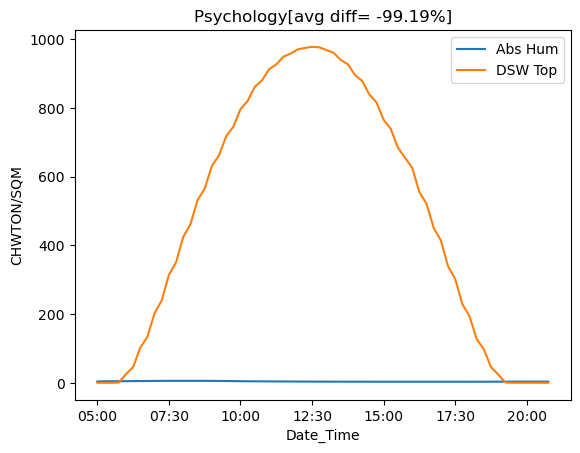

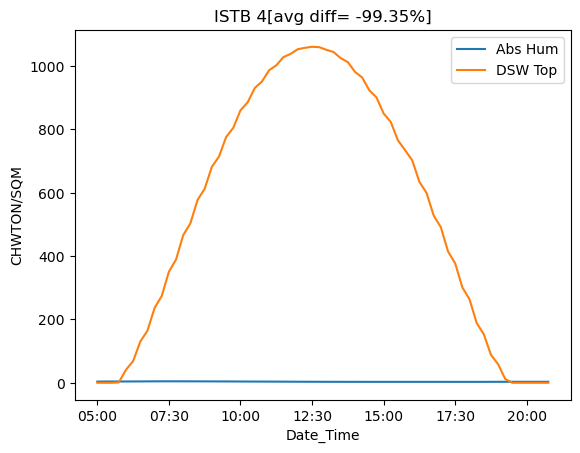

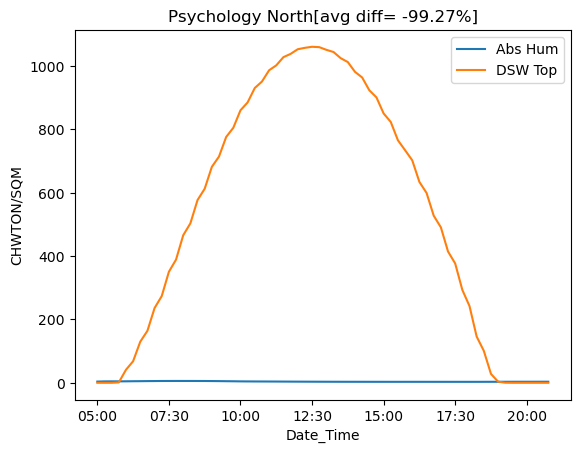

In [27]:
# 1. predict test data and create df_bldgs
y_pred = model.predict(X_test)
df_combined_test, df_bldgs_test = data_obj.create_df_bldgs(y_pred, y_test, is_val=False, is_scenario=False)


# 2. plot
plt_obj = Plot()
for df_bldg in df_bldgs_test:
    print(df_bldg)
    plt_obj.plot(df_bldg, "actual", output_path=OUTPUT_PATH, is_save=False)
    

In [ ]:
# 3. predict training data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                      y_train_val, 
                                                      test_size=0.3, 
                                                      random_state=20)
y_pred_val = model.predict(X_val)
df_combined_val, df_bldgs_val = data_obj.create_df_bldgs(y_pred_val,
                                                         y_val, is_val=True,
                                                         is_scenario=False)

In [ ]:
# 1. init scoring object
scoring_obj = Scoring()

# 2. compute scores for each bldg
for df_bldg in df_bldgs_test:
    scoring_obj.compute_all_metrics(df_bldg, MODEL_NAME)
    
for df_bldg in df_bldgs_val:
    scoring_obj.compute_r2_val(df_bldg, MODEL_NAME)
    
    
# # 3. compute scores combined
scoring_obj.compute_all_metrics(df_combined_test, MODEL_NAME)
scoring_obj.compute_r2_val(df_combined_val, MODEL_NAME)

# # 4. grab result
df_scores = scoring_obj.get_df_scores()
df_scores

In [ ]:
scoring_obj.save_scores_csv(OUTPUT_PATH, MODEL_NAME)

In [ ]:
scenario = Scenario(X_test, model)

# 1. make prediction 
y_scen_pred = scenario.get_scenario_prediction("Air Temp")

# 2. get the result df
df_combined, df_bldgs = data_obj.create_df_bldgs(y_pred, 
                                                 y_scen_pred, 
                                                 is_val=False,
                                                 is_scenario=True)

# 3. plot
for df_bldg in df_bldgs:
    plt_obj.plot(df_bldg, 
                 "AirTemp", 
                 output_path=OUTPUT_PATH, 
                 is_save=False)

In [ ]:
# 1. make prediction 
y_scen_pred = scenario.get_scenario_prediction("combined")

# 2. get the result df
df_combined, df_bldgs = data_obj.create_df_bldgs(y_pred, 
                                                 y_scen_pred, 
                                                 is_val=False, 
                                                 is_scenario=True)

# 3. plot
for df_bldg in df_bldgs:
    plt_obj.plot(df_bldg, 
                 "combined", 
                 output_path=OUTPUT_PATH, 
                 is_save=False)

# 10.Tuning Best (Catboost)

In [ ]:
cb_reg_grid = {
        'depth': [9,10,11],
        'learning_rate' : [0.02, 0.03, 0.04],
        'l2_leaf_reg': [1, 2],
        'n_estimators' : [400, 500, 600],
        'verbose': [False],
        'loss_function': ['RMSE'],
        }

print(CB.get_base_name())

cb_gridsearch, cb_grid_name = CB.set_get_reg_grid(cb_reg_grid), CB.get_grid_name()
cb_best_grid = tt.train_and_store_score(cb_gridsearch, cb_grid_name)
tt.test_and_store_score(cb_best_grid, cb_grid_name)
tt.explainerObj.plot(cb_best_grid, cb_grid_name)

In [ ]:
scores_df = tt.get_scores_df()
print(scores_df)

In [ ]:
# catboost_best_random = {'learning_rate': 0.03, 
#                       'depth': 6,
#                       'l2_leaf_reg': 1,
#                       'loss_function': 'RMSE',
#                       'verbose': False,
#                       'n_estimators': 1000}
